In [28]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [7]:
session_times = pd.read_csv('data/web_page_data.csv')

### 재표본추출 - 순열검정

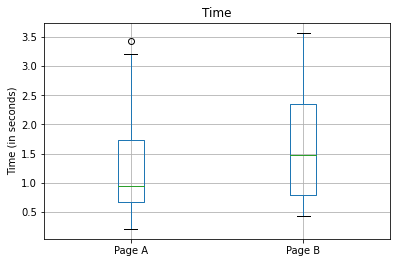

In [6]:
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.show()

페이지 b가 방문객들을 더 오래 붙잡는 것으로 보인다.

In [8]:
# 각 페이지별 시간에 대한 평균을 비교한 것이다. b페이지가 a와 비교했을때, 세션시간이 더 길다. 
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

0.35666666666666713


위에서 나온 차이가 실제적으로 우연인지, 아님 통계적으로 중요한것인지 판단하기 위해 순열검정을 적용한다.

In [11]:
# 페이지 a와 페이지b를 랜덤하게 할당한다.
# perm_fun 함수는 비복원추출방식으로 nB개의 표본을 추출하고 그룹 Bdp 에 할당한다 그리고 나머지 nA개는 그룹 A에 할당한다.
# 이때 두평균의 차이를 결과로 반환한다. 

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n),nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

-0.010190476190476527


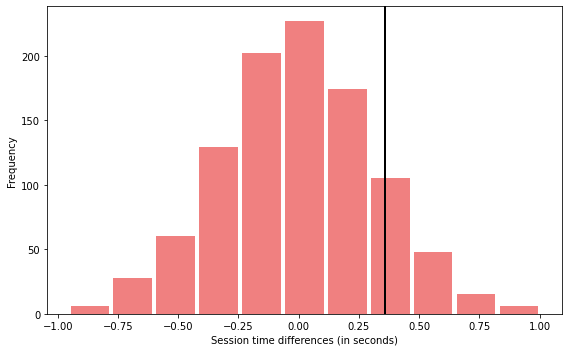

In [25]:
# 위에서 구한 코드를 바탕으로 1000번 반복. 
# 실제 관찰된 세션시간의 차이가 가끔 수직선을 넘어가는 것을 확인 된다.

random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9, color = 'lightcoral')
ax.axvline(x = mean_b - mean_a, color='black', lw=2) # 실제 관찰된 세션 시간의 차이 0.356
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [47]:
temp = [ 1 if p > (mean_b - mean_a) else 0 for p in perm_diffs]
print('실제 값보다 ', (sum(temp) / 1000) * 100 ,'% 더 넘었다.')

실제 값보다  12.1 % 더 넘었다.


이는 페이지 A와 페이지 B사이의 세션 시간의 차이가 확률 분포의 범위 내에 있음을 의미하고 따라서 차이는 통계적으로 유의하지 않다. 

### p값

In [53]:
example = pd.DataFrame({'가격 A' :[ 200 , 23739], '가격  B': [182 , 22588] },
             index = ['전환', '미전환'])
example

,가격 A,가격 B
전환,200,182
미전환,23739,22588


가격 A는 가격 B보다 0.0368% 더 나은 전환결과를 보여준다. 데이터가 많고 전환의 갯수가 차이가 많이 날때는 유의미 할 수 있지만, 위의 결과처럼 빅데이터일 경우여도 전환율이 너무 낮을 경우 ( 200개밖에 안됨) 우연일지에 대한 고민을 해봐야한다.

Observed difference: 0.0368%


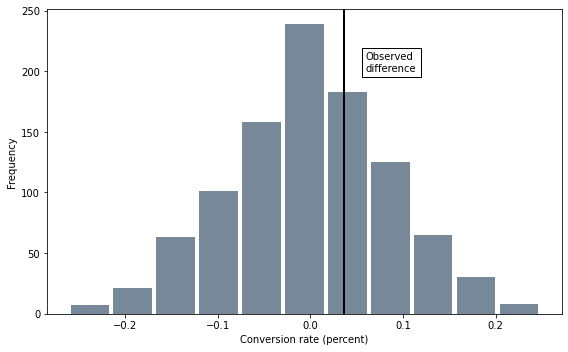

In [56]:
# 1. 순열검정

random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9, color = 'lightslategray')
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

1,000개의 재표본추출 결과를 보여준다. 이 경우 0.0268%의 차이는 랜덤 변이의 범위내에 있다. 따라서 통계적으로 유의하지 않다. 

In [57]:
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.332

p 값은 0.332이다. 즉, 우연히 얻은 결과의 30%정도가 관찰한 것과 비슷한 정도로 예외적인 결과를 얻을 것으로 기대된다.

### 이항분포의 정규근사법 - P값

In [58]:
from scipy import stats

survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498
